In [1]:
#This notebook used the following dataset: https://www.kaggle.com/datasets/sergylog/ab-test-data

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ab-test-data/AB_Test_Results.csv


This notebook was created on Kaggle, so many of the basic kaggle features are included

To start, I'll do some basic exploratory data analysis to get a basic understanding of our dataset and a direction of where to go with my hypothesis test

In [2]:
df = pd.read_csv('/kaggle/input/ab-test-data/AB_Test_Results.csv')

df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [3]:
df.tail()

,USER_ID,VARIANT_NAME,REVENUE
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0
9999,9468,control,0.0


In [4]:
df.columns

Index(['USER_ID', 'VARIANT_NAME', 'REVENUE'], dtype='object')

I want to check if any users were both in the variant and control group

In [5]:
df.groupby(by = 'USER_ID').VARIANT_NAME.nunique().value_counts()

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

There are 1,541 users in both groups. I will drop these users since I do not know which treatment influenced their decision

In [6]:
one_var_user = (df.groupby(by = 'USER_ID').VARIANT_NAME.nunique() == 1)

one_var_users = one_var_user[one_var_user].index

one_var_users

Int64Index([   2,    4,    5,    6,    9,   11,   12,   13,   15,   19,
            ...
            9976, 9980, 9983, 9986, 9989, 9990, 9992, 9993, 9995, 9998],
           dtype='int64', name='USER_ID', length=4783)

In [7]:
df = df[df.USER_ID.isin(one_var_users)]

df.reset_index(inplace = True, drop = True)

df

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,6174,variant,0.0
2,2380,variant,0.0
3,9168,control,0.0
4,7548,control,0.0
...,...,...,...
6065,2400,variant,0.0
6066,3129,control,0.0
6067,502,variant,0.0
6068,7741,control,0.0


In [8]:
df.USER_ID.value_counts()

5652    6
1339    5
1782    5
9152    4
8573    4
       ..
9730    1
2924    1
293     1
9670    1
9468    1
Name: USER_ID, Length: 4783, dtype: int64

Some users are in this dataset multiple times. Since I know now that they only received one treatment (I dropped all users who got multiple ones), I can make their revenue value the sum of the amounts they spent in all their purchases

In [9]:
df = df.groupby(by = ['USER_ID', 'VARIANT_NAME']).sum()

df.reset_index(inplace = True)

df

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,4,variant,0.0
2,5,variant,0.0
3,6,variant,0.0
4,9,variant,0.0
...,...,...,...
4778,9990,variant,0.0
4779,9992,control,0.0
4780,9993,control,0.0
4781,9995,variant,0.0


In [10]:
df.USER_ID.value_counts()

2       1
6674    1
6672    1
6671    1
6668    1
       ..
3331    1
3330    1
3327    1
3326    1
9998    1
Name: USER_ID, Length: 4783, dtype: int64

Now, I only have each user once in our dataset

I investigate if there are any users who were outliers and spent a lot. If there are few, they will be dropped

In [11]:
df.sort_values(by = 'REVENUE').tail()

,USER_ID,VARIANT_NAME,REVENUE
1779,3684,variant,19.47
514,1053,control,20.07
3511,7356,variant,23.04
1054,2166,control,29.32
1601,3342,control,196.01


In [12]:
df = df[df.USER_ID != 3342]

df.reset_index(inplace = True, drop = True)

df.sort_values(by = 'REVENUE').tail()

,USER_ID,VARIANT_NAME,REVENUE
137,282,control,18.56
1778,3684,variant,19.47
514,1053,control,20.07
3510,7356,variant,23.04
1054,2166,control,29.32


In [13]:
df.sort_values(by = 'REVENUE').head()

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
3178,6640,variant,0.0
3177,6637,variant,0.0
3176,6636,variant,0.0
3175,6634,variant,0.0


In [14]:
df.groupby('VARIANT_NAME').REVENUE.mean()

VARIANT_NAME
control    0.114923
variant    0.074935
Name: REVENUE, dtype: float64

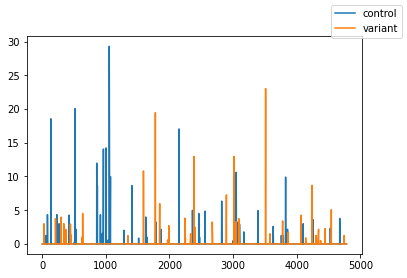

In [15]:
fig = plt.figure()

df.groupby('VARIANT_NAME').REVENUE.plot()

fig.legend()

The data does not appear to be normally distributed for either group

In [16]:
df.groupby('VARIANT_NAME').REVENUE.var()

VARIANT_NAME
control    1.351394
variant    0.736520
Name: REVENUE, dtype: float64

The samples have inequal variances

The mean revenue of the 'control' group appears to be greater than that of the 'variant' group. 

I am interested in determining whether or not there is a statistically signifcant difference in the revenues generated by the two methods. I will do this by A/B testing. The null hypothesis will be that there is no difference in the average revenue generates. The alternative hypothesis will be that there is a difference


I will use an alpha value of 0.05

In [17]:
alpha = 0.05

I will use a 2-sample Wech's T-Test since the variances are unequal

In [18]:
from scipy import stats

In [19]:
control = df[df.VARIANT_NAME == 'control'].REVENUE
variant = df[df.VARIANT_NAME == 'variant'].REVENUE

In [20]:
control

0       0.0
5       0.0
6       0.0
7       0.0
11      0.0
       ... 
4773    0.0
4776    0.0
4778    0.0
4779    0.0
4781    0.0
Name: REVENUE, Length: 2389, dtype: float64

In [21]:
variant

1       0.0
2       0.0
3       0.0
4       0.0
8       0.0
       ... 
4771    0.0
4774    0.0
4775    0.0
4777    0.0
4780    0.0
Name: REVENUE, Length: 2393, dtype: float64

In [22]:
result = stats.ttest_ind(control, variant, equal_var = False)

In [23]:
if result.pvalue > alpha:
    print(f" The p value was {result.pvalue} and we failed to reject null hypothesis")

else:
    print(f" The p value was {result.pvalue} and we reject the null hypothesis")

 The p value was 0.1761207039161098 and we failed to reject null hypothesis


The p-value was greater than 0.05, so I cannot conclude a statistically significant difference in the revenue generated between the two methods